# Handin 2: OCR with SVM and (Deep) Neural Nets 
In the previous handin you built an optical character recognition (OCR) classifier. The best classifiers achieved around 90% accuracy on the test set. The goal of this handin is to build more complicated classifiers that hopefully achieve better performance. The performance of your final classifier will be tested on a set of unknown images we have kept secret. 

There are four parts to the handin:
1. Support Vector Machines 
2. Feed Forward Neural Nets using Tensorflow 
3. Convolutional Neural Nets using Tensorflow
4. (Optional) Use anything you learned in the course to optimize accuracy in a competition with your fellow students and the TA's.

Each part is explained in detail below after the intro section.  

# Intro
### Formalities
The maximal report length is 5 pages. You are allowed to be up to 3 members in a
group.  You are encouraged to discuss the exercise between groups and
help each other as much as possible **without of course copying each
other's work**. Particularly, discussing the quality of your classifiers
is probably a good idea to get an indication of whether you are doing it
correctly. For these discussions and additional questions use the
discussion forum on the Blackboard course site.

* You must upload a pdf report and a zip archive of the .py files and the relevant model weights in the model_weights folder.
Use the python script *zip_code_results.py*. If you make exercise 4 and make a great classifier be sure to add the name of the stored weights file to zip_code_results.py (hopefully that will make more sense when you have done the exercise).


### Important remarks
* The discussion board and google are your friends!
* Note that running the experiments may be rather slow, so start running experiments early -- don't wait until the day before the deadline!
* Questions are always welcome on the Blackboard discussion board. Be sure to actually formulate a precise question of what the issue is.
* As always use the study-cafe as well.


## Support Vector Machines
Support Vector Machiens were explained in detail in the <a href="http://cs229.stanford.edu/notes/cs229-notes3.pdf">SVM note</a>. In this exercise you will not have to implement the SVM's yourself. An implemetation is available in the Python package called *sklearn*. We will use this without caring about the specifics of how it was implemented. This can be be done using the following two lines:  <br><br>

<div style="margin-left: 16px;">clf = svm.SVC(kernel='linear', C=1)<br>
clf.fit(DATA, LABELS)</div>

The following example loads the AU Digits and trains a SVM on the data. The SVM formulation we use is for binary classifier so we need to apply one vs. all. This is specified by *decision_function_shape="ovr"*. 

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import os

# from h2_utils
def load_train_data():
    if not os.path.exists('auTrain.npz'):
        os.system('wget https://users-cs.au.dk/jallan/ml/data/auTrain.npz')
    tmp = np.load('auTrain.npz')
    return tmp['digits'], tmp['labels']

def load_test_data():
    if not os.path.exists('auTest.npz'):
        os.system('wget https://users-cs.au.dk/jallan/ml/data/auTest.npz')
    tmp = np.load('auTest.npz')
    return tmp['digits'], tmp['labels']
    
images, labels = load_train_data()
images_test, labels_test = load_test_data()

print("Training... \t(This could take a few minutes!)")

# Thanks to the SKLearn library, these two lines of code handles all the training!
# We don't need to implement ANYTHING!
clf = svm.SVC(kernel='linear', C=1, decision_function_shape="ovr") # Note that ovr is default we only write to make it clear here.
clf.fit(images, labels)

print("Training done!")

Training... 	(This could take a few minutes!)
Training done!


When the training is done, you can run the following code to see how well it performs!

In [4]:
print("Computing in-sample and test accuracies...\t (This might also take a few minutes!)")
in_sample_accuracy = (clf.predict(images)==labels).mean()
print('In-sample Acc:\t {:.2%}'.format(in_sample_accuracy))
test_accuracy = (clf.predict(images_test)==labels_test).mean()
print('Test Acc:\t {:.2%}'.format(test_accuracy))

Computing in-sample and test accuracies...	 (This might also take a few minutes!)
In-sample Acc:	 99.71%
Test Acc:	 92.09%


On my computer this gave in-sample accuracies around 99% and test accuracies around 92%. This is not bad! In the first handin most people got <a target="new" href="https://cs.au.dk/~alexmath/highscore.php">test scores</a> around 91%. Two calls to a Python library beats almost all handin 1 classifiers! It seems to be overfitting so there may be possible to squeeze out more from the linear SVM.

In the above model we used the linear kernel and $C=1$ (cost of wrong side of margin). How should we choose which <a target="new" href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html">kernel</a> (linear, polynomial, rbf, ...) and which parameters $C$ to use? Validation! That is, for each choice of kernel we define an (exponentially) decreasing list of options for $C$ and then compute the validation estimate.

Let us consider an example of the RBF kernel (here we also have a kernel parameter $\gamma$). To help us do this we use the GridSearchCV class from the *sklearn* library. Read the documentation for help. Note that GridSearchCV actually parallelizes the computation of the validation scores if you let it.

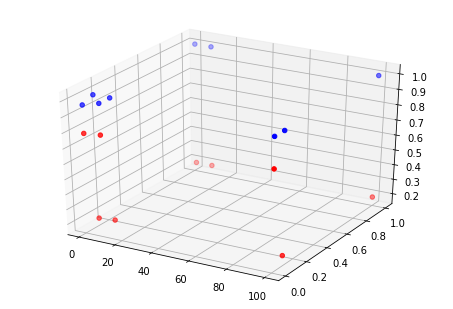

C:		 [1 1 1 10 10 10 100 100 100]
gamma:		 [0.01 0.1 1 0.01 0.1 1 0.01 0.1 1]
test_acc:	 [ 0.79  0.19  0.19  0.8   0.2   0.19  0.8   0.2   0.19]
train_acc:	 [ 0.97034866  1.          1.          1.          1.          1.          1.
  1.          1.        ]


In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
from IPython.display import display 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

'''
    Do Cross Validation on Support Vector Machine with RBF kernel 
    for C in [1,10,100] and gamma in [0.01, 0.1, 1]
'''
def svc_cv(X, Y):
    clf = SVC(kernel='rbf')
    parameters = {
        'C': [1, 10, 100],
        'gamma': [0.01, 0.1, 1]
    }
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1) 
    gs_clf = gs_clf.fit(X, Y)   
    return gs_clf.cv_results_
    

# Do Cross Validation only on the first 100 points to speed everything up. 
# You want to use more points when you do the real Cross Validation.
cv = svc_cv(images[0:100], labels[0:100])

# Fetch out test/train scores, C and gamma values
C = cv['param_C']
gamma = cv['param_gamma']
test_scores = cv['mean_test_score']
train_scores = cv['mean_train_score']

# Plot them (if you do this in real Python instead of Ipython notebook you can change the plot perspective)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(C, gamma, test_scores, color="red")
ax.scatter(C, gamma, train_scores, color="blue")
plt.show()

# You should try printing the entire output of the Cross Validation
# We have uncommented it because it prints A LOT of stuff. 
# Try run the code, inspect the scatter plot, then uncomment
# the line below and run the code again. 
print("C:\t\t", C)
print("gamma:\t\t", gamma)
print("test_acc:\t", test_scores)
print("train_acc:\t", train_scores)

### Your job
The following table (to the left) shows you which kernels and parameters you should experiment with. The table to the right gives an example with the RBF kernel for $C$ in $[1, 100]$ and $\gamma$ in $[0.01, 1]$. 
<center>
<table style="display: inline-block;">
<tr>
<td><b>Kernel</b></td>
<td><b>Parameters</b></td>
</tr>
<tr>
<td>Linear Kernel</td><td>C</td>
</tr>
<td><a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.polynomial_kernel.html">Polynomial Kernel</a></td><td>C, d, coef0 (at least try $d=2$ and $d=3$)</td>
<tr>
<tr>
<td><a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html">RBF kernel</a></td><td>C, $\gamma$ ($\lambda$ in notes)</td>
</tr>
</table>

<table style="display: inline-block;">
<tr style="font-weight: bold; ">
<td>C</td>
<td>$\gamma$</td>
<td>Test Accuracy</td>
<td>Train Accuracy</td>
</tr>
<tr><td> 1 </td><td> 0.01 </td><td> 0.79 </td><td> 0.970348664287 </td></tr>
<tr><td> 1 </td><td> 1 </td><td> 0.19 </td><td> 1.0 </td></tr>
<tr><td> 100 </td><td> 0.01 </td><td> 0.8 </td><td> 1.0 </td></tr>
<tr><td> 100 </td><td> 1 </td><td> 0.19 </td><td> 1.0 </td></tr>
</table></center>

<b>Exercise 1: </b>In the file **svm.py** write Cross Validation code that tests the kernels and parameters described above. You might find some of the above code useful.  

**HINT:** When doing Cross Validation it may be worthwhile scaling down the data set size when doing the initial experiments, similar to $n=100$ as done above. 

**HINT:** You can use the pandas library to export/save your results to files. See the Python code below and *export_dataframe* in *model_stats*.




In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
from IPython.display import display 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

'''
    Do Cross Validation on Support Vector Machine with RBF kernel 
    for C in [1,10,100] and gamma in [0.01, 0.1, 1]
'''
def svc_cv(X, Y):
    clf = SVC(kernel='rbf')
    parameters = {
        'C': [1, 10, 100],
        'gamma': [0.01, 0.1, 1]
    }
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1) 
    gs_clf = gs_clf.fit(X, Y)   
    return gs_clf.cv_results_
    

# Do Cross Validation only on the first 100 points to speed everything up. 
# You want to use more points when you do the real Cross Validation.
cv = svc_cv(images[0:100], labels[0:100])

# Create a DataFrame object using the cross validation result and filter out the 
# relevant information. Finally display/print it. 
dataframe = pd.DataFrame(cv) 
relevant = dataframe.filter(['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score', 'param_C', 'param_gamma', 'mean_fit_time']).sort_values(['mean_test_score'])
display(relevant)

# Save the data to a file, then load it again and print it. 
filename = 'results/svc_rbf.csv'
relevant.to_csv(filename, index=False)
df = pd.read_csv(filename)
print('display it again after loading it')
display(df)

,mean_test_score,mean_train_score,std_test_score,std_train_score,param_C,param_gamma,mean_fit_time
1,0.19,1.000000,0.005754,0.000000,1,0.1,0.015046
2,0.19,1.000000,0.005754,0.000000,1,1,0.012458
5,0.19,1.000000,0.005754,0.000000,10,1,0.010613
8,0.19,1.000000,0.005754,0.000000,100,1,0.009273
4,0.20,1.000000,0.008515,0.000000,10,0.1,0.011244
7,0.20,1.000000,0.008515,0.000000,100,0.1,0.008946
0,0.79,0.970349,0.051492,0.011372,1,0.01,0.013616
3,0.80,1.000000,0.098742,0.000000,10,0.01,0.012726
6,0.80,1.000000,0.098742,0.000000,100,0.01,0.009192


display it again after loading it


,mean_test_score,mean_train_score,std_test_score,std_train_score,param_C,param_gamma,mean_fit_time
0,0.19,1.000000,0.005754,0.000000,1,0.10,0.015046
1,0.19,1.000000,0.005754,0.000000,1,1.00,0.012458
2,0.19,1.000000,0.005754,0.000000,10,1.00,0.010613
3,0.19,1.000000,0.005754,0.000000,100,1.00,0.009273
4,0.20,1.000000,0.008515,0.000000,10,0.10,0.011244
5,0.20,1.000000,0.008515,0.000000,100,0.10,0.008946
6,0.79,0.970349,0.051492,0.011372,1,0.01,0.013616
7,0.80,1.000000,0.098742,0.000000,10,0.01,0.012726
8,0.80,1.000000,0.098742,0.000000,100,0.01,0.009192


### Report and Deliverables
For each experiment include a table similar to the pandas table above. This gives 3+ results tables, depending on how many degrees you consider for polynomial kernels (it makes sense to make a table for each degree).

For each kernel (or all of them at once) shortly explain how you came up with the values you have tested and include the training accuracy and the test accuracy of the best classifier found using that kernel (for that use the entire data set). No more than a few lines.

Finally, state which kernel (of all the different kernels you checked) works best and state the performance achieved (on the entire train and test set).


## Neural Nets
In this part of the handin we will use Neural Networks to do OCR. We will use Google's Open Source Framework for numerical computation, Tensorflow. 

First you should read the tensorflow guide provided with the exercise description. It is important that you understand the Tensorflow implementation of Logistic Regression and Softmax. Everything has already been implemented, you just need to read and understand it! <b>Reading the guide might take around an hour, it is fairly long:</b>  

As is evident there is a lot of boiler plate code to use tensorflow. We have organized that and made starter code for you so you can focus on the task of implementing neural nets.
In **model.py** there are classes for a simple framework for making Tensorflow models and starter code for the two different neural net architectures can be found in **nn_model.py** and **cnn_model.py**. Each file has several pieces of code you need to fill in marked with *### YOUR CODE ###, ### END CODE ###*. 

Note that each file has its own configuration class which is a simple container for storing hyperparameters and define the file path to where the network weights are stored. 

** Your job is to complete these two code files to get two running neural nets for optical character recognition.**

Below we shortly discuss what you need to implement.




### Standard Feed Forward Neural Net
Using the template **nn_model.py** you must implement a standard one hidden layer neural net with relu non-linearity using weight decay and dropout as regularization.
We will use this network for recognizing digits so the last part of the neural net is a softmax. As described in the Tensorflow note Softmax is built into Tensorflow. The training algorithm is Gradient Descent, but luckily Tensorflow supports automatic differentation, so all you need to compute is the output of the neural net before the Softmax and later the regularized cost. As stated in the lecture and at the TA class the output of the neural net can be written as 

$$
W_2 \textrm{relu}(W_1 X + b_1) + b_2
$$

where $X$ is the data, $W_1, W_2$ are weight matrices (each column is the weights for a neuron) and $b_1,b_2$ are bias weights.
The bias $b_1$ and $b_2$ has to be added to each row of the matrix they are added to.

You need to add dropout regularization and weight decay. Dropout has to be added to the the formula above in Tensorflow and Weight Decay to the cost.

This is also explained in the comments for *add_prediction_op* in the code template.

To be formal weight decay is defined as

$$
\lambda (\sum_{i,j} W_1[i,j]^2 + \sum_{i,j} W_2[i,j]^2 )
$$

and should be added in the *add_loss_op* method.

### Convolutional Net Feed Forward Neural Net
To see if we can improve on optical character recognition we will make a convolutional net.
It essentially corresponds to starting the network with two convolution, pooling, nonlinearity layers the result of which are then feed into a standard neural net as you just implemented. So assuming you have made the neural net above, the hard part is to figure out how to implement the convolutional layers. Tensorflow comes equipped with the tools for handling these so you need to figure out how to apply them.

The two first convolutions you need to compute are on the form
* l1 = max_pool(Relu(conv(x, C1)))
* l2 = max_pool(Relu(conv(l1, C2)))
The input to the first convolution is the input. To apply tensorflows convolution operators we must reshape the input to an image form (if this is not already the input shape, which is not in our case).

So given an input matrix $X$ of size $n \times d=784$, we must reshape it into an $(n, 28, 28, 1)$ shape matrix (tensor). In Tenforflow we represent arbitrary size inputs using -1 so it actually becomes $(-1,28,28,1)$.

The 28 x 28 you should recognize as the image input dimensions. The final one is the number of layers in the image. In our case the images are grayscale and thus have only one channel. For RGB images for instance there would be three i.e. in general a  (-1, height, width, channels) tensor (4D matrix) is used.

This is the format the convolution operator understands. See <a href="https://www.tensorflow.org/api_docs/python/tf/nn/conv2d">tf.nn.conv2d</a> for an explanation. This function requires several arguments which you should read up on. The primary ones for our case is the convolution filter.

*filter: A Tensor. Must have the same type as input. A 4-D tensor of shape [filter_height, filter_width, in_channels, out_channels]*

If we want to make 32, 5 x 5 pixels convolutions filters on the input, which has one channel then filter become (5,5,1,32)

Note that the output of such a convolution operator here will be a new "image" shaped tensor with 32 channels.

Pooling on top of a convolution we also have to specify the size of the pools and then how much they should shift. In our case we will shift the pooling by the size of the pool so these two becomes the same value. 

The convolution and pooling parameters are specified in the config class for the convolutional neural net.

The values for the remaining parameters are specified in the code file.

After the convolution layers the current value of the data that is sent up the network is still in image form so you must reshape it and to do that you need to know the reshape size.
To be able to do that you must finish the code in the Config file for computing the size of the output of the convolutional layers and use it when you construct the network.

For the convolutional net we use only dropout as a regularizer but you are most welcome to add weight_decay

### Deliverables
* Complete the implementation in nn_model.py. When you are done run model_stays -nn to create standard statistics as in handin 1. This will generate the following files in the results folder that you must include in your report (and present them nicely).
  - nn_early_stopping_256.csv
  - nn_256_confusion_matrix.csv
  - nn_256_early_stopping.png
  - nn_256_stats_accuracy.csv    
* Complete the implementaion in cnn_model.py. When you are done run model_stays -cnn to create standard statistics as in handin 1. This will generate the following files in the results folder that you must include in your report (and present them nicely).
  - cnn_early_stopping_1024.csv
  - cnn_1024_confusion_matrix.csv
  - cnn_1024_early_stopping.png
  - cnn_1024_stats_accuracy.csv    

** Hint: ** As stated in the tensorflow guide you can look in *logistic_model.py* for inspiration if you are stuck somewhere.

** If you would like to visualize your neural nets take a look at visualize_models.py and follow the instructions**

For all the bells and whistles see the very cool animated deep learning for MNIST digits at http://cs.stanford.edu/people/karpathy/convnetjs/demo/mnist.html

We only provide some of that functionality but the idea of how it is done should be evident if you want to add more.

## Report
Include the figures generated from model_stats and comment each result in a few lines. Then answer
the following theoretical questions. (assume matrix multiplication of an a x b and b x c matrix takes a * b * c operations)
* How many parameters $(U, W, b_1, b_2)$ are there in the neural net from nn_model.py with hidden layer size 256? general formula with hidden layer size h? 
* How many operations (+, *) does it take to compute the forward pass (pred in add_prediction_op) for the single hidden layer neural network, with hidden size 1024 and for general h?
* How many parameters are there in the convolutional net from cnn_model.py with hidden layer size conv_layers = [(5, 5, 1, 32), (5, 5, 32, 64)]
  , pool_sizes = [2, 2] and hidden size 1024? 
     
  How many (+, *) operations does it take to compute the forward pass (pred in add_prediction_op) for the convolutional net?
  

  


## (Optional) Competition: The best classifier in 2017 ML Class

The final exercise is a competiton between all students of this years ML class and then a *standard* solution provided by the course staff.
You must deliver the best AU digits classifier you can and upload as part of the hand-in
(the format is described below).

Your classifier may be based SVMs and Neural Nets -- whichever you get the best results from.

We will evaluate all classifiers we receive on a hidden data set that none of you have seen (assume they are from the same distribution as the training set).
If a classifier takes excessively long time it will be killed and get a score of 0.
The group that has the highest accuracy (lowest error) wins a prize (this could be the TAs).

At the last lecture we will show the results of your labor and
declare a winner. As stated the TA also enters the competition with a
baseline classifier, which as stated, you must beat to win the prize, as well of course beating all the other students -- so get creative. 

Below we have provided a few pointers to things you could try.
However, you don't have to use any of it -- it is really up to you.
The format for uploading your classifier is as follows.
You have to make a Python 3 file that contains a function named `predict` that takes as input a matrix `X` of input images (i.e. a $n \times 784$ matrix where $n$ is the number of test images and 784 is the dimension of the images we consider).
The name of the file should be **predict.py** and be sure to test it before you upload.
**Remember to include the model weights/parameters in the model_weights in the ZIP-archive. See zip_code_results.py for how to do that**

### Example code structure

For instance, if you decide to use SVM as your best classifier, your may have a training file `train.py` that look like:

In [4]:
# train.py
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1)
clf.fit(images, labels)
np.savez_compressed('model_weights/myfile.npz', my_model=clf)

Then, your `predict.py` may define the function `predict` as follows:

In [5]:
# predict.py
from sklearn import svm
def predict(input):
    # initialize stuff like your model
    tmp = np.load('model_weights/myfile.npz')
    my_model = tmp['my_model'].item()  # item because np.savez_compressed saves numpy arrays...
    # predict with your model
    res = my_model.predict(input)
    assert len(res) == input.shape[0]
    # return predictions
    return res

**If you use Tensorflow**, you can just make a new model class or use one you already have made and experiment with different configurations.
Your predict function would then look something like below (note that nn_model saves the weights in file named as a function of only the hidden layer size unless you provide an additional name suffix to the config constructor)

In [6]:
import nn_model as nn
def predict(input):
    config = {'hidden_size': 512} # same config 
    model = Classifier(nn.FeedForwardModel, nn.Config(name_suffix='THE_BEAST', **config))
    pred = model.predict(input)
    return pred


ModuleNotFoundError: No module named 'nn_model'

Finally, we will have a secret test file that loads your `predict` function and runs it on the secret test data.
You may imagine our file looks something like:

In [ ]:
# secret_evaluation_code.py

# Import the predict function if it doesn't already exist
try:
    predict
except NameError:
    from predict import predict

def evaluate_student_classifier():
    ten_predictions = predict(images_test[0:13])
    correct = labels_test[0:13]
    assert ten_predictions.shape == correct.shape
    accuracy = np.mean(ten_predictions == correct)
    print("The student gets {:.2%} points".format(accuracy))

evaluate_student_classifier()

## Deliverables

* Explain the best classifier you found and the quality of it
* A python file predict.py that has a predict function as described.
Remember to update *zip_code_results.py* with the name of your weights file it begin svm or neural net.

## Report
After you have done all your experiments you must select what you
think is the best classifier possible.  Describe the classifier you decide on in the report, give us any additional validation estimates you have used for your decision and give an estimate of how well it will work on the unknown data and a reason for
that estimate (you should use the test data for that).

Remember to create the python file(s) that can evaluate your classifier on an input matrix of images
(that are formatted as the training data) as described above and upload in a zip file alongside your report. 

### Making the Best AU OCR Classifier
Here are some things you can apply to have a better chance of winning
the competition.

#### Tensorflow Convolutional Nets
Convolutional Nets are the state of the art in such image recognition scenarios, so we suggest you start with your current implementation of a convolutional net and start from there. The solution architecture you already implemented  follows the [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.11/tutorials/index.html) tutorial of Tensorflow, so you can try to improve on that. The tutorial is a guide on how to attack the MNIST digits, but as you have seen it works reasonably well for the AU digits as well.
** Remember to make a new class and not overwrite the one you must hand in unless the only thing you change is the configuration **
* Add or remove layers and change their sizes
* Change regularization, experiment with parameters.
* Add more regularization of other kinds. You have to figure ways to do that your self.
* Try different initialization strategies
* Run for a very long time
* Artifically generate more data by considering the task we are given.
A picture of a 5 is still a 5 even if add a little random noise to the
image, or if you stretch, scale, rotate or translate, the image slightly.
The *scipy.ndimage* module has a lot of functionality.
Read more here:
https://scipy-lectures.github.io/advanced/image_processing/
The convolutional nets should have some built in invariance to such things but it should still help.

* Use MNIST, The MNIST digits is 60.000 train images + 10.000 test images you can 
  use, but they may not behave the same way as the AU data set. 
* Add your own features
* Any fancy preprocessing
